# 1. Import dependencies and configure the environment

In [39]:
import os

import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [24]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Load and preview the data

Found 75000 files belonging to 5 classes.
Class 0: Arborio
Class 1: Basmati
Class 2: Ipsala
Class 3: Jasmine
Class 4: Karacadag


2023-09-03 01:10:46.903779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [75000]
	 [[{{node Placeholder/_4}}]]
2023-09-03 01:10:46.904095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [75000]
	 [[{{node Placeholder/_4}}]]


[]

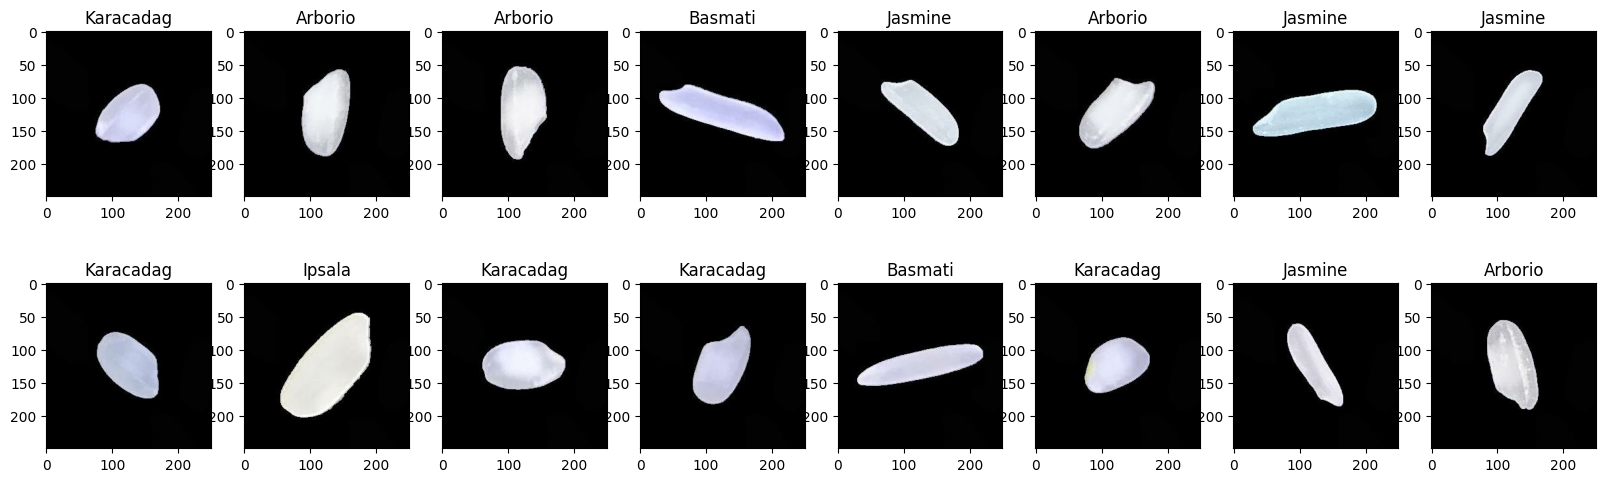

In [25]:
dataset_dir = 'data'
dataset = tf.keras.utils.image_dataset_from_directory(dataset_dir, image_size=(250,250), batch_size=32)

class_names = dataset.class_names
def map_int_labels_to_str(label):
    return class_names[label]
for idx, class_name in enumerate(class_names):
    print(f'Class {idx}: {class_name}')

# Normalize pixel values to the range 0 and 1
dataset = dataset.map(lambda X, y: (X/255,y))

# Preview 
batch = dataset.as_numpy_iterator().next()
fig, ax = plt.subplots(figsize=(20,6), nrows=2, ncols=8)
ax = ax.flatten()
for idx, img in enumerate(batch[0][:16]):
    ax[idx].set_title(map_int_labels_to_str(batch[1][idx]))
    ax[idx].imshow(img)
plt.plot()

# 3. Split the dataset for training, validation and testing

In [26]:
# Use 70% of batches for training, 20% for validation and 10% for testing
batch_count = len(dataset)
train_size = int(batch_count * 0.7)
val_size = int(batch_count * 0.2)
test_size = int(batch_count * 0.1)
# If there any leftover batches, use them for testing
train_size += batch_count - train_size - val_size - test_size

train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size).skip(val_size).take(test_size)

# 4. Define the model

In [36]:
model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), input_shape=(250,250,3), activation='relu'),
    Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(4,4)),

    Flatten(),
    
    Dense(units=300, activation='relu'),
    Dense(units=120, activation='relu'),
    Dense(units=40, activation='relu'),
    Dense(units=5, activation='softmax'),
])

model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 248, 248, 16)      448       
                                                                 
 conv2d_25 (Conv2D)          (None, 244, 244, 32)      12832     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 122, 122, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 118, 118, 32)      25632     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 59, 59, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 57, 57, 64)       

# 5. Fit the model, save it, and plot the model's performance

Epoch 1/25


2023-09-03 02:11:04.778631: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


1642/1642 [==============================] - 173s 102ms/step - loss: 0.1315 - accuracy: 0.9533 - val_loss: 0.1048 - val_accuracy: 0.9638
Epoch 2/25
1642/1642 [==============================] - 167s 102ms/step - loss: 0.0871 - accuracy: 0.9716 - val_loss: 0.0771 - val_accuracy: 0.9752
Epoch 3/25
1642/1642 [==============================] - 170s 103ms/step - loss: 0.0728 - accuracy: 0.9765 - val_loss: 0.0653 - val_accuracy: 0.9790
Epoch 4/25
1642/1642 [==============================] - 170s 103ms/step - loss: 0.0524 - accuracy: 0.9831 - val_loss: 0.0749 - val_accuracy: 0.9744
Epoch 5/25
1642/1642 [==============================] - 170s 103ms/step - loss: 0.0376 - accuracy: 0.9879 - val_loss: 0.0663 - val_accuracy: 0.9795
Epoch 6/25
1642/1642 [==============================] - 171s 104ms/step - loss: 0.0269 - accuracy: 0.9920 - val_loss: 0.0334 - val_accuracy: 0.9886
Epoch 7/25
1642/1642 [==============================] - 175s 106ms/step - loss: 0.0205 - accuracy: 0.9937 - val_loss: 0.020

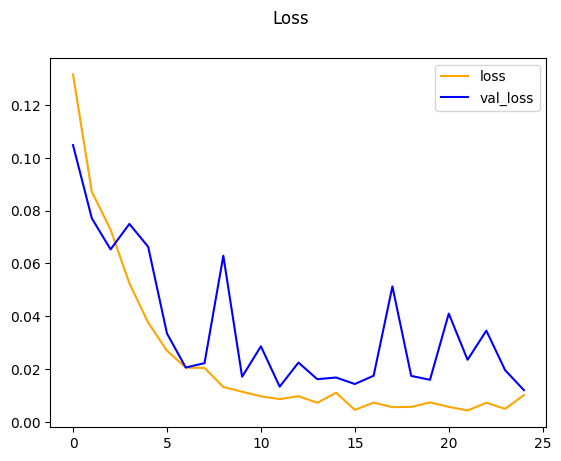

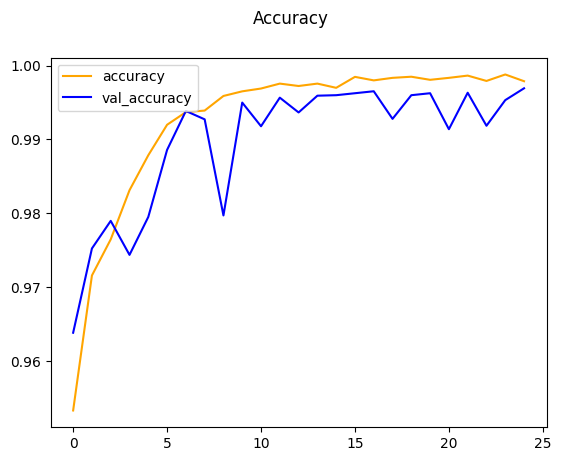

In [37]:
hist = model.fit(train, epochs=25, validation_data=val)
model.save(os.path.join('models', 'model2.keras'))
           
fig = plt.figure()
fig.suptitle('Loss')
plt.plot(hist.history['loss'], color='orange', label='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
plt.legend()
plt.show()

fig = plt.figure()
fig.suptitle('Accuracy')
plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
plt.legend()
plt.show()

# 6. Test the model performance

Accuracy: 0.9963904023170471


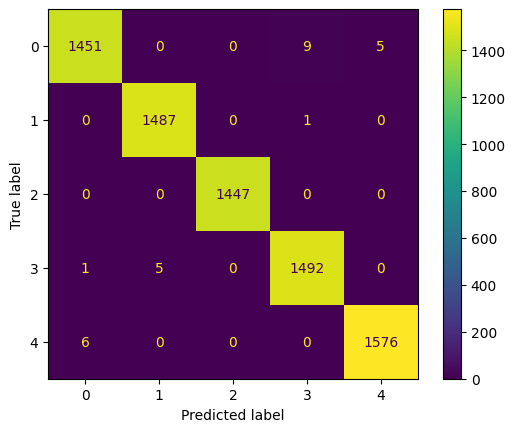

In [55]:
accuracy = Accuracy()
y_all = np.empty(shape=(0))
y_hat_all = np.empty(shape=(0))

for batch in test:
    X, y = batch
    y_hat = model.predict(X, verbose=0)
    accuracy.update_state(y, np.argmax(y_hat, axis=1))
    y_all = np.concatenate((y_all, y))
    y_hat_all = np.concatenate((y_hat_all, np.argmax(y_hat, axis=1)))
     
# Print the accuracy and display the confusion matrix
print(f'Accuracy: {accuracy.result()}')
cm = confusion_matrix(y_all, y_hat_all)
ConfusionMatrixDisplay(cm).plot()